In [1]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.optimize import minimize

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNK = 0  # unknow word-id
PAD = 1  # padding word-id

from core.datasets.datasets import *
from core.datasets.sim import *
from core.models.transformer import *
from core.trains.train import *

DATABASE = './nk'
illuminant = SDS_ILLUMINANTS['D65']
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

mats = ['Al', 'Ag', 'Al2O3', 'AlN', 'Ge', 'HfO2', 'ITO', 'MgF2', 'MgO', 'Si', 'Si3N4', 'SiO2', 'Ta2O5', 'TiN', 'TiO2', 'ZnO', 'ZnS', 'ZnSe', 'Glass_Substrate']
thicks = [str(i) for i in range(10, 505, 10)]

lamda_low = 0.4
lamda_high = 1.1
wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.01)

nk_dict = load_materials(all_mats = mats, wavelengths = wavelengths, DATABASE = DATABASE )

def spectrum(materials, thickness, pol = 's', theta=0,  wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000):
    '''
    Input:
        metal materials: list  
        thickness: list
        theta: degree, the incidence angle

    Return:
        All_results: dictionary contains R, T, A, RGB, LAB
    '''
    #aa = time.time()
    degree = pi/180
    theta = theta *degree
    wavess = (1e3 * wavelengths).astype('int')
        
    thickness = [np.inf] + thickness + [substrate_thick, np.inf]

    R, T, A = [], [], []
    inc_list = ['i'] + ['c']*len(materials) + ['i', 'i']
    for i, lambda_vac in enumerate(wavess):

        n_list = [1] + [nk_dict[mat][i] for mat in materials] + [nk_dict[substrate][i], 1]

        res = inc_tmm(pol, n_list, thickness, inc_list, theta, lambda_vac)

        R.append(res['R'])
        T.append(res['T'])

    return R + T

    
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (5, 4)
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlepad'] = 10
mpl.rcParams.update({'font.size': 15})

import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/arial.ttf')
plt.rcParams['font.family'] = 'Arial'

In [2]:

a = torch.load('saved_models/ol_transformer/in_paper/ol_transformer.pt')  # best model 

args = a['configs']
torch.manual_seed(args.seeds)
np.random.seed(args.seeds)
model = make_model(
                args.struc_dim, 
                args.spec_dim,
                args.layers, 
                args.d_model, 
                args.d_ff,
                args.head_num,
                args.dropout
            ).to(DEVICE)

model.load_state_dict(a['model_state_dict'])
loss = a['loss_all']
criterion = torch.nn.MSELoss()
count_params(model)

65083463

In [3]:

TRAIN_FILE = './dataset/Structure_trial_0.pkl'   
TRAIN_SPEC_FILE = './dataset/Spectrum_trial_0.pkl'  
DEV_FILE = './dataset/Structure_trial_1.pkl'   
DEV_SPEC_FILE = './dataset/Spectrum_trial_1.pkl'  


data = PrepareData(TRAIN_FILE, TRAIN_SPEC_FILE, args.ratios, DEV_FILE, DEV_SPEC_FILE, args.batch_size, 'R_T')

data.train_struc, data.train_spec = data.load_data(TRAIN_FILE, TRAIN_SPEC_FILE, args.ratios)
data.dev_struc, data.dev_spec = data.load_data(DEV_FILE, DEV_SPEC_FILE)
data.struc_word_dict,  data.struc_index_dict = a['configs'].struc_word_dict, a['configs'].struc_index_dict

# 03. word to id by dictionary 
data.train_struc_id = data.wordToID(data.train_struc, a['configs'].struc_word_dict)
data.dev_struc_id = data.wordToID(data.dev_struc, a['configs'].struc_word_dict)

# 04. batch + padding + mask
data.train_data_B = data.splitBatch(data.train_struc_id, data.train_spec, args.batch_size)
data.dev_data_B   = data.splitBatch(data.dev_struc_id, data.dev_spec, args.batch_size)


0.00017772421415429562


Text(0.5, 1.0, 'Training curve')

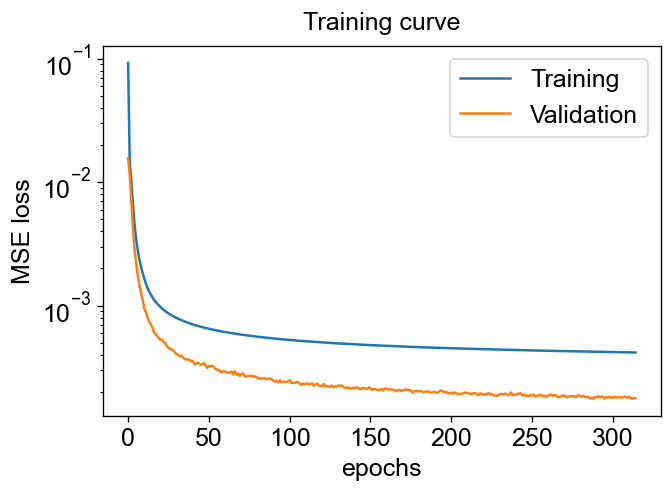

In [4]:
fig = plt.figure(dpi=120, figsize=[6, 4])
fig.patch.set_facecolor('white')

loss_train = [i.to('cpu').item() for i in a['loss_all']['train_loss']]
loss_eval = [i.to('cpu').item() for i in a['loss_all']['dev_loss']]
print(loss_eval[-1])
plt.plot(loss_train, label='Training')
plt.plot(np.array(loss_eval), label='Validation')
plt.legend()
# plt.ylim(3, 6)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.title('Training curve')

# Compare the simulation time single by single

In [5]:
def return_mat_thick(struc_list):
    materials = []
    thickness = []
    for struc_ in struc_list:
        materials.append(struc_.split('_')[0])
        thickness.append(struc_.split('_')[1])

    return materials, thickness

In [6]:
criterion = torch.nn.MSELoss()

N = 1000


layers = []
all_specs_pred = np.zeros([N, 142])
all_specs_ori = np.zeros([N, 142])

time_sim = []
time_tf = []
start = time.time()
model.eval()

with torch.no_grad():
    
    for i in tqdm(range(N)):
        
        src = torch.from_numpy(np.array([data.dev_struc_id[i]])).long()
        layers.append(len(data.dev_struc_id[i]) - 2)
        src_mask = (src != 0).unsqueeze(-2)
        trg = torch.tensor(data.dev_spec[i]).float()
        aa = time.time()
        out = model(src.to(DEVICE),  src_mask.to(DEVICE))
        bb = time.time()
        
        all_specs_pred[i :] = np.array(out.to('cpu'))
        all_specs_ori[i, :] = data.dev_spec[i]
        
        material_d, thickness_d =  return_mat_thick(data.dev_struc[i][1:-1])
        cc = time.time()
        spec = spectrum(material_d, thickness_d, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
        dd = time.time()
        
        time_tf.append(bb - aa)
        time_sim.append(dd - cc)
        
        
end = time.time()
print('Finished in ', end- start)
loss_each = np.mean(np.square(all_specs_pred - all_specs_ori), axis=1)
loss_mae = np.mean(np.abs(all_specs_pred - all_specs_ori), axis=1)


100%|██████████| 1000/1000 [01:26<00:00, 11.57it/s]

Finished in  86.4175112247467


In [7]:
np.mean(time_tf), np.mean(time_sim), np.mean(loss_each), np.mean(loss_mae)

(0.010040021657943725,
 0.075724869489669805,
 4.8555243009963008e-05,
 0.0040648978495252232)

# Compare the performance in validation dataset

In [10]:
criterion = torch.nn.MSELoss()

start = time.time()
total_tokens = 0.
total_loss = 0.
tokens = 0.
all_specs_pred = np.zeros([1000000, 142])
all_specs_ori = np.zeros([1000000, 142])
struc = []
materials = []
thicknesss = []

model.eval()
j  = 0
time_tf1 = []
with torch.no_grad():
    for i , batch in tqdm(enumerate(data.dev_data_B)):
        aa = time.time()
        out = model(batch.src.to(DEVICE),  batch.src_mask.to(DEVICE))
        bb = time.time()
        time_tf1.append(bb - aa)
        loss = criterion(out, batch.trg.to(DEVICE))
        all_specs_pred[j:j+out.size(0), :] = np.array(out.to('cpu'))
        all_specs_ori[j:j+out.size(0), :] = np.array(batch.trg.to('cpu'))
        
        j += out.size(0)

loss_each = np.mean(np.square(all_specs_pred - all_specs_ori), axis=1)
loss_mae = np.mean(np.abs(all_specs_pred - all_specs_ori), axis=1)
print('Total loss:', total_loss/i)

1000it [03:57,  4.21it/s]


Total loss: 0.0


In [11]:
np.mean(time_tf1), np.mean(loss_each), np.mean(loss_mae)

(0.01469489860534668, 5.7174530401603611e-05, 0.0042888421593310008)

# Evaluate a give type of structures

In [14]:

import random 
random.seed(100)
np.random.seed(100)


struc_temp = ['Ag', 'SiO2', 'Ag']
struc_temp = ['SiO2', 'Si3N4',  'SiO2', 'Si3N4', 'SiO2', 'Si3N4']
struc_temp = ['MgF2', 'SiO2',  'Al2O3', 'TiO2', 'Si', 'Ge']
struc_temp = ['SiO2', 'Si3N4',  'SiO2', 'Si3N4']*5
# struc_temp = ['TiO2', 'SiO2',  'Al2O3', 'Si3N4', 'ZnO', 'ZnS', 'ITO', 'HfO2', 'Si']
# struc_temp = ['ZnS', 'TiO2',  'MgO', 'ZnS', 'Si3N4', 'ITO', 'SiO2', 'TiO2', 'Ta2O5', 'ZnO', 'Al2O3', 'Ag']


len_temp = len(struc_temp)
struc_eval = []

N = 1000
thicks = [10*i for i in range(1, 51)]
thicks_Ag = [10, 20, 30, 40, 50]

for i in range(N):
    # thick_temp = random.sample(thicks_Ag, 1) + random.sample(thicks, 1) + random.sample(thicks_Ag, 1)
    thick_temp = random.sample(thicks, len_temp)
    struc_eval_ = [struc_temp[j] + '_' + str(thick_temp[j]) for j in range(len_temp)]
    struc_eval.append(['BOS'] + struc_eval_ + ['EOS'])

struc_eval_id = data.wordToID(struc_eval, a['configs'].struc_word_dict)


In [81]:

all_specs_pred = np.zeros([N, 142])
all_specs_ori = np.zeros([N, 142])

time_sim = []
time_tf = []
start = time.time()
model.eval()

with torch.no_grad():
    
    for i in tqdm(range(N)):
        
        src = torch.from_numpy(np.array([struc_eval_id[i]])).long()
        src_mask = (src != 0).unsqueeze(-2)

        out = model(src.to(DEVICE),  src_mask.to(DEVICE))
        all_specs_pred[i :] = np.array(out.to('cpu'))
        
        material_d, thickness_d =  return_mat_thick(struc_eval[i][1:-1])
        spec = spectrum(material_d, thickness_d, wavelengths = wavelengths, nk_dict= nk_dict, substrate = 'Glass_Substrate', substrate_thick = 500000)
        all_specs_ori[i, :] = spec
        
end = time.time()
print('Finished in ', end- start)
loss_each = np.mean(np.square(all_specs_pred - all_specs_ori), axis=1)
loss_mae = np.mean(np.abs(all_specs_pred - all_specs_ori), axis=1)

100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]

Finished in  98.21692156791687


In [82]:
np.mean(loss_each), np.mean(loss_mae)

(0.0011489962695487022, 0.024232331483033009)

Text(0, 0.5, 'Count')

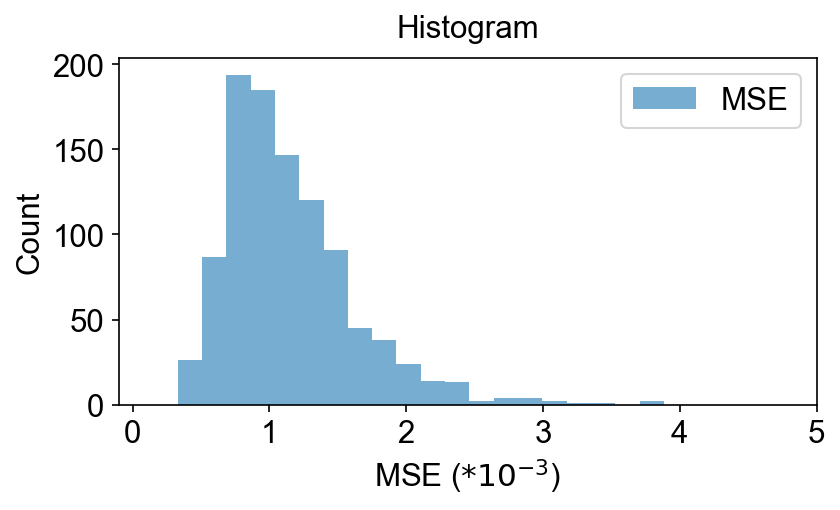

In [83]:
fig = plt.figure(dpi=150, figsize=[6, 3])

fig.patch.set_facecolor('white')
ax = plt.subplot(111)
plt.hist(np.array(loss_each)*1000, bins = 20, alpha=0.6, label='MSE')
plt.legend()
plt.xlim([-0.1, 5])
plt.xlabel('MSE ($*10^{-3}$)')
plt.title('Histogram')
plt.ylabel('Count')

['BOS', 'SiO2_290', 'Si3N4_410', 'SiO2_220', 'Si3N4_500', 'SiO2_480', 'Si3N4_270', 'SiO2_360', 'Si3N4_170', 'SiO2_30', 'Si3N4_70', 'SiO2_420', 'Si3N4_10', 'SiO2_110', 'Si3N4_460', 'SiO2_240', 'Si3N4_340', 'SiO2_40', 'Si3N4_350', 'SiO2_400', 'Si3N4_60', 'EOS']


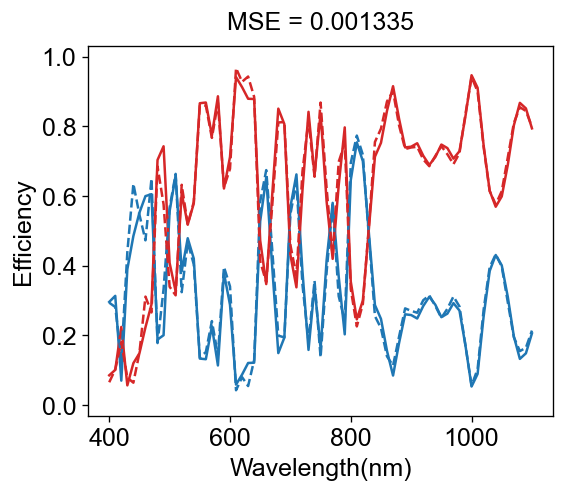

In [86]:
temp = 111
# temp = 22
waves = np.linspace(400, 1100, 71)

fig = plt.figure(dpi=120, figsize=[5, 4])
fig.patch.set_facecolor('white')
print(struc_eval[temp])
plt.plot(waves, all_specs_ori[temp, :71], color='tab:blue', label='R - Real')
plt.plot(waves, all_specs_ori[temp,  71:], color='tab:red', label='T - Real')

plt.plot(waves, all_specs_pred[temp,  :71], color='tab:blue', linestyle='--', label='R - Predicted')
plt.plot(waves, all_specs_pred[temp, 71:], color='tab:red', linestyle='--', label='T - Predicted')

plt.ylim(-0.03, 1.03)

# plt.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncols=6)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Efficiency')
# plt.title(str(temp) + '\n'+ ' '.join(struc_eval[temp][1:-1])+'\n \nMSE = '+str(round(loss_each[temp], 6)))
plt.title('MSE = '+str(round(loss_each[temp], 6)))
plt.show()

# Visualize the attention 

In [6]:
import altair as alt
import pandas as pd

In [11]:
def get_spec_mat(mat_thick, dicts = data.struc_word_dict):
    # return the input to transformer model 

    ans = [dicts['BOS']]
    strucss = ['BOS']
    for i in range(len(mat_thick)):
        temp = mat_thick[i]
        strucss.append(temp)
        ans.append(dicts[temp])
    ans.append(dicts['EOS'])
    ans = np.array([ans])
    ans = torch.from_numpy(ans).long()
    strucss.append('EOS')
    return ans, (ans != 0).unsqueeze(-2), strucss


In [15]:

temp_struc_close_kp = ['SiO2_240', 'Ta2O5_90', 'SiO2_130', 'TiO2_80', 'MgF2_140', 'HfO2_80', 'SiO2_130', 'Ta2O5_100', 'SiO2_130', 'Ta2O5_180', 'SiO2_80', 'Ta2O5_160'] # good for attention

mat_temp, thick_temp = return_mat_thick(temp_struc_close_kp)
spec_target = spectrum(mat_temp, thick_temp)


src = torch.tensor([spec_target]).unsqueeze(0).float().to(DEVICE)
src_mask = None

src, src_mask, struc_rep = get_spec_mat(temp_struc_close_kp)

model.eval()
with torch.no_grad():
    # out = model(src.to(DEVICE), Variable(trg).to(DEVICE), src_mask, trg_mask.to(DEVICE))
    spec_p = model(src.to(DEVICE), src_mask.to(DEVICE)).to('cpu').detach().numpy()
    attn = [model.encoder.layers[i].self_attn.attn for i in range(12)]
    # attn = [model.decoder.layers[i].src_attn.attn for i in range(6)]



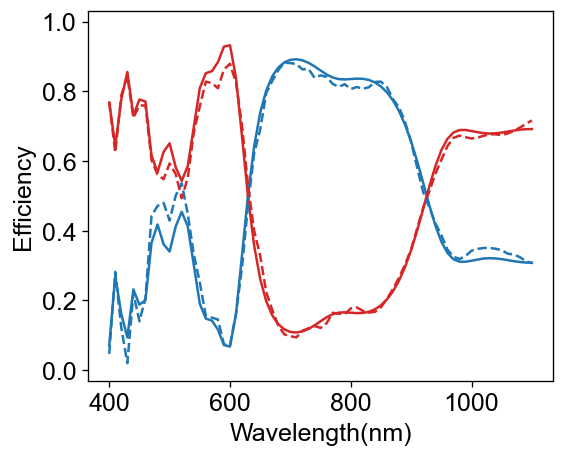

In [18]:

waves = np.linspace(400, 1100, 71)

fig = plt.figure(dpi=120, figsize=[5, 4])
fig.patch.set_facecolor('white')

plt.plot(waves, spec_target[:71], color='tab:blue', label='R - Real')
plt.plot(waves, spec_target[71:], color='tab:red', label='T - Real')

plt.plot(waves, spec_p[0,  :71], color='tab:blue', linestyle='--', label='R - Predicted')
plt.plot(waves, spec_p[0, 71:], color='tab:red', linestyle='--', label='T - Predicted')

plt.ylim(-0.03, 1.03)

# plt.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncols=6)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Efficiency')
# plt.title(str(temp) + '\n'+ ' '.join(struc_eval[temp][1:-1])+'\n \nMSE = '+str(round(loss_each[temp], 6)))
# plt.title('MSE = '+str(round(loss_each[temp], 6)))
plt.show()

In [19]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
                # "%s"
                # % (row_tokens[r] if len(row_tokens) > r else "<blank>"),
                # "%s"
                # % (col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=22):
    df = mtx2df(
        attn[layer][0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=200, width=200)
        .interactive()
    )

def visualize_layer(attn, layer,n_heads, row_tokens, col_tokens, ntokens=22):
    # ntokens = last_example[0].ntokens

    charts = [
        attn_map(
            attn,
            layer,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    return alt.vconcat(
        charts[0]
        # | charts[1]
        # | charts[2]
        # | charts[3]
        # | charts[4]
        # | charts[5]
        # | charts[6]
        # | charts[7]
        # | charts[8]
        # | charts[9]
        # | charts[10]
        # | charts[11]
        # | charts[12]
        # | charts[13]
        # | charts[14]
        | charts[15]
        # layer + 1 due to 0-indexing
    ).properties(title="Block %d" % (layer + 1))




In [20]:
layer_viz = [
    visualize_layer(
        attn, layer, 16, struc_rep, struc_rep, ntokens=22
    )
    for layer in range(12)
]

alt.hconcat(
    layer_viz[0]
    # & layer_viz[1]
    # & layer_viz[2]
    # & layer_viz[3]
    # & layer_viz[4]
    # & layer_viz[5]
    # & layer_viz[6]
    # & layer_viz[7]
    # & layer_viz[8]
    # & layer_viz[9]
    # & layer_viz[10]
    # & layer_viz[11]
)


/home/taigaom/anaconda3/envs/transformer/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

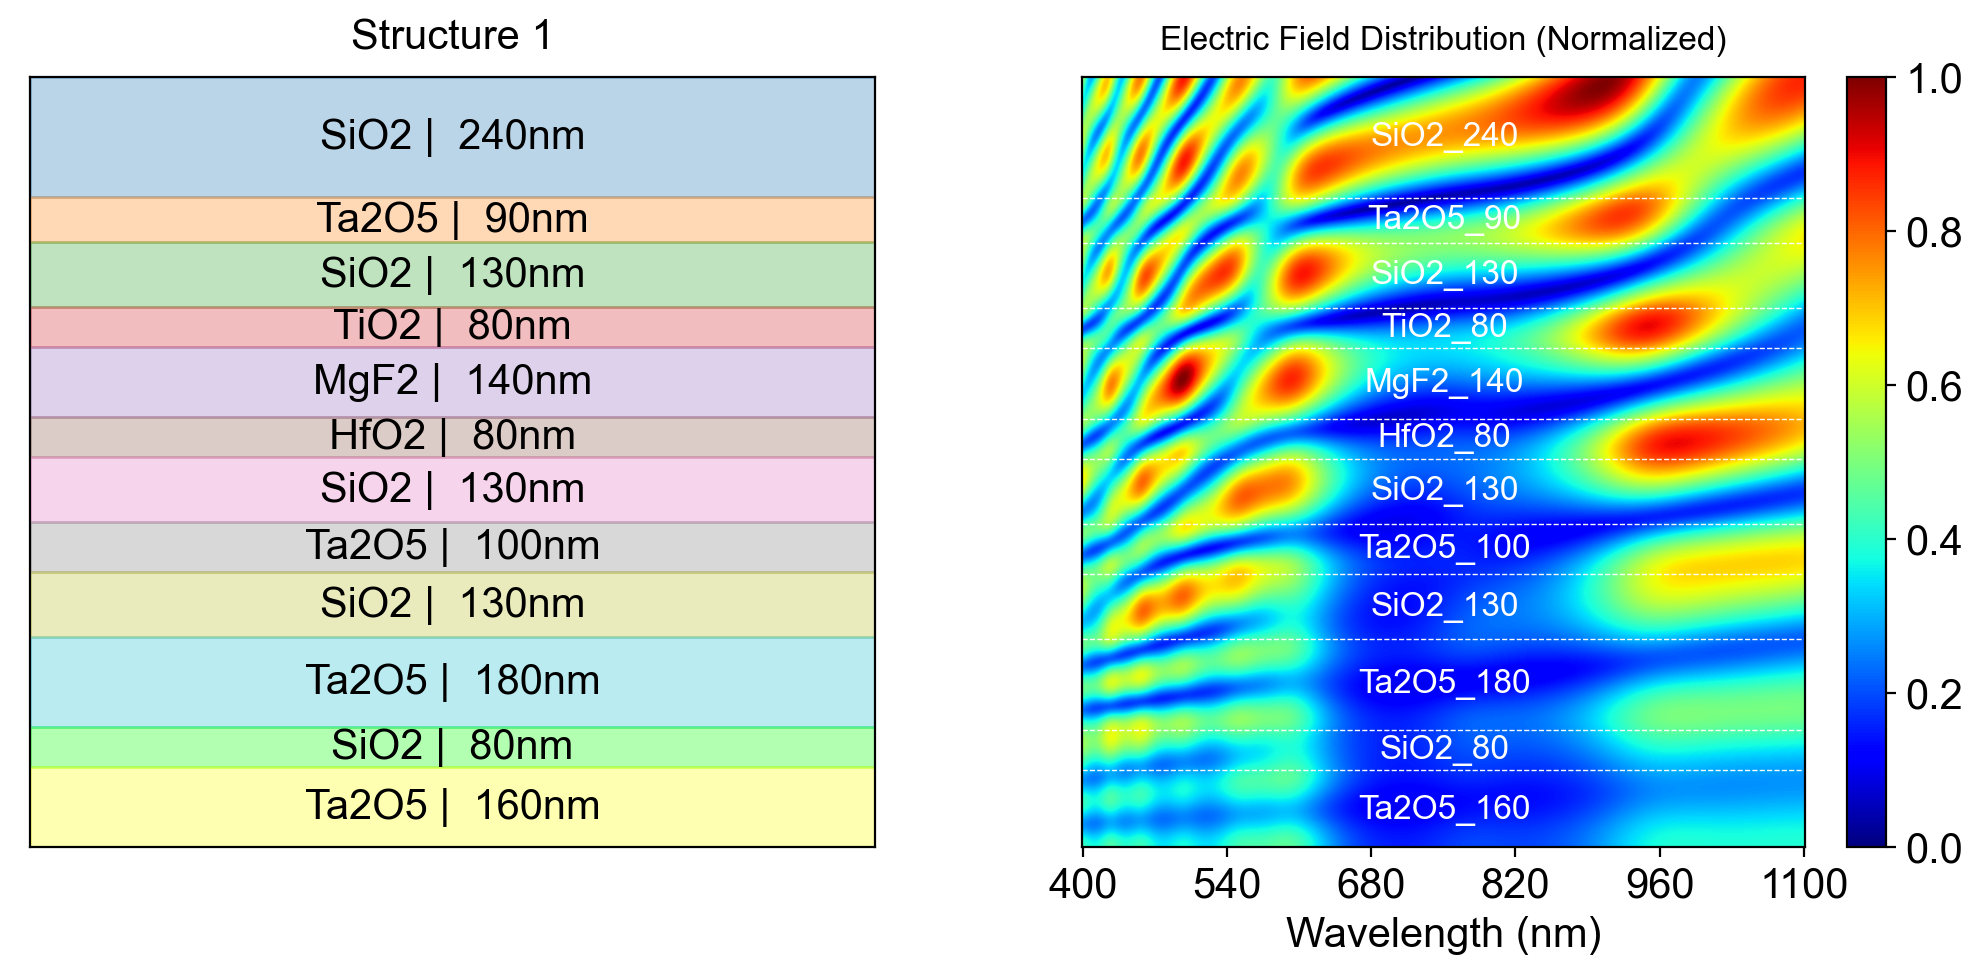

In [22]:
# plot the electrical field

# plot the electrical field and show the overall structure
from tmm import coh_tmm, inc_tmm, position_resolved, find_in_structure_with_inf
import matplotlib.patches as patches
# define the cal_field 
def Cal_field(materials, thickness, theta=0, pol = 's', wavelengths = wavelengths, nk_dict= nk_dict, acc_dep = 100):
    '''
    Input:
        materials: list
        thickness: list
        mixing_ratio: list
        theta: degree, the incidence angle
        acc_dep: number of points along thickness
    Return:
        s: array, spectrum
    '''
    #print(materials, thickness, mixing_ratio)
    D = sum(thickness)
    D_step = np.linspace(0, D+1, num=acc_dep)
    #thickness = [np.inf] + thickness + [50000000, np.inf]
    thickness = [np.inf] + thickness + [np.inf]

    degree = pi/180

    field = np.zeros([acc_dep, len(wavelengths)])
    poyn = np.zeros([acc_dep, len(wavelengths)])
    absor = np.zeros([acc_dep, len(wavelengths)])
    for i, lambda_vac in enumerate(wavelengths * 1e3):

        nk_wave = []
        for ii in range(len(materials)):
            mat = materials[ii]
            nk_wave.append(nk_dict[mat][i])

        inc_list = ['i'] + ['c']*len(nk_wave) + ['i', 'i']
        n_list = [1] + nk_wave + [nk_dict['SiO2'][i], 1]
        n_list = [1] + nk_wave + [nk_dict['SiO2'][i]]

        #print(n_list, thickness)
        res = coh_tmm(pol, n_list, thickness, theta * degree, lambda_vac)
        #res = inc_tmm(pol, n_list, thickness, inc_list, theta * degree, lambda_vac)  # solve the tmm
        for j in range(len(D_step)):
            layer, d_in_layer = find_in_structure_with_inf(thickness, D_step[j])
            data = position_resolved(layer, d_in_layer, res)
            field[j, i] = np.sqrt(np.abs(data['Ex']) ** 2  + np.abs(data['Ey']) ** 2 + np.abs(data['Ez'] ** 2))
            poyn[j, i] = data['poyn']
            absor[j, i] = data['absor']

    return poyn, absor, field
# wavelengths_new = np.arange(0.3, 1.6001, 0.001)
# nk_dict_new = load_materials(wavelengths = wavelengths_new)

# acc_dep = 500
# incident_angle = 0

wavelengths_new = np.arange(0.4, 1.1001, 0.0025)
nk_dict_new = load_materials(wavelengths = wavelengths_new)

acc_dep = 300
incident_angle = 0


pol = 's'
materials, thickness = return_mat_thick(temp_struc_close_kp)
thickness = [int(i) for i in thickness]
Poynt, Absorb, E_field = Cal_field(materials, thickness ,pol = pol, theta = incident_angle, wavelengths = wavelengths_new, nk_dict = nk_dict_new, acc_dep = acc_dep)

Poynt = Poynt/np.max(Poynt)
Absorb = Absorb/np.max(Absorb)
E_field = E_field/np.max(E_field)
E_field = E_field

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})
fig.patch.set_facecolor('white')
im = ax[1].imshow(E_field, cmap='jet', interpolation =  'spline16', aspect = 1, vmin=0, vmax=1)
plt.colorbar(im, ax=ax[1], fraction = 0.05)
yticks = np.arange(0, 1.1, 0.2)
y_ticks = np.floor(yticks*acc_dep)
yticklabels = np.floor(yticks*sum(thickness))
ax[1].set_yticks(y_ticks)
# ax[1].set_yticklabels(np.intc(yticklabels), fontsize=15)
ax[1].set_yticks([1000])
ax[1].set_yticklabels([], fontsize=15)

ax[1].set_ylim(len(E_field)-1, 0)

xticks = np.arange(0, 1.05, 0.2)
x_ticks = [int(i) for i in xticks*(len(wavelengths_new)-1)]
xticklabels = wavelengths_new[x_ticks]*1000
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(np.intc(xticklabels), fontsize=15)
ax[1].set_xlabel('Wavelength (nm)', fontsize=15)
# ax[1].set_ylabel('Depth (nm)', fontsize=15)
ax[1].set_title('Normalized Absorption', fontsize=15, pad=15)
ax[1].set_title('Electric Field Distribution (Normalized)', fontsize=12, pad=10)



starts = np.cumsum(np.array(thickness)/sum(thickness))
mat_pos = [np.sum(thickness[:(i+1)])/np.sum(thickness)*len(E_field) for i in range( len(thickness)-1) ]
for ii in range(len(thickness)):
    mat = materials[ii]
    label_mat = mat
    if mat not in ['Air', 'Glass']:
        # label_mat = label_mat+ ' ' + str(thickness[ii]) +'nm'
        label_mat = label_mat+ '_' + str(thickness[ii])
        
    
    ax[1].text(x=0.5*len(wavelengths_new), y=(starts[ii]  - 0.5*thickness[ii]/sum(thickness))*len(E_field), s=label_mat, color='white', fontsize=12, horizontalalignment='center', verticalalignment='center')

for ii in range(len(mat_pos)):
    ax[1].axhline(y = mat_pos[ii], ls = '--', color='white', linewidth = 0.5)



starts = np.cumsum(np.array(thickness)/sum(thickness))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',  'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime','yellow', 'tab:green', 'tab:red',  'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime','yellow',  'tab:brown', 'tab:pink', 'tab:gray',  'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'tab:orange', 'tab:green', 'tab:red',  'tab:purple' ]
for ii in range(len(thickness)):
    mat = materials[ii]
    label_mat = mat +' |  '+ str(round(thickness[ii], 1))+'nm'
    rect = patches.Rectangle((0, 1 - starts[ii]), 1, thickness[ii]/sum(thickness), linewidth=1, edgecolor=colors[ii], facecolor=colors[ii], alpha=0.3)
    ax[0].add_patch(rect)
    ax[0].text(x=0.5, y=1 - starts[ii] + 0.5*thickness[ii]/sum(thickness), s=label_mat, horizontalalignment='center', verticalalignment='center')
ax[0].set_title('Structure 1')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()




# Visualize the hidden representation of structures 


In [93]:
model.eval()

with torch.no_grad():
    hidden_index = torch.tensor([i for i in range(904)])
    hidedn_struc = model.src_embed[0](hidden_index.to(DEVICE)).to('cpu').data
    hidedn_struc = np.array(hidedn_struc)

struc_word_dict,  struc_index_dict = a['configs'].struc_word_dict, a['configs'].struc_index_dict

mat_index = {}
for i in range(len(mats[:-1])):
    temp_index = []
    for j in range(50):
        temp_index.append(struc_word_dict[mats[i]+'_'+str(10*j+10)])
    mat_index[mats[i]] = temp_index

In [94]:
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
from umap import UMAP

np.random.seed(20)
min_max_scaler = preprocessing.MinMaxScaler()
all_design = hidedn_struc
all_design_norm = min_max_scaler.fit_transform(hidedn_struc)

time_start = time.time()

tsne = TSNE(n_components=2, perplexity = 5, random_state = 20, n_iter = 600)   # looks good 
tsne_results = tsne.fit_transform(all_design_norm)

# umap_model = UMAP(learning_rate = 1, n_components = 2, min_dist = 0.5, spread = 2, transform_seed = 20, n_neighbors = 5, n_epochs = 1000)
# umap_results = umap_model.fit_transform(all_design_norm)
# tsne_results = umap_results

# pca_model = PCA(n_components = 2)
# pca_results = pca_model.fit_transform(all_design_norm)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


/home/taigaom/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


t-SNE done! Time elapsed: 2.301419258117676 seconds


Text(0.5, 1.0, 't-SNE')

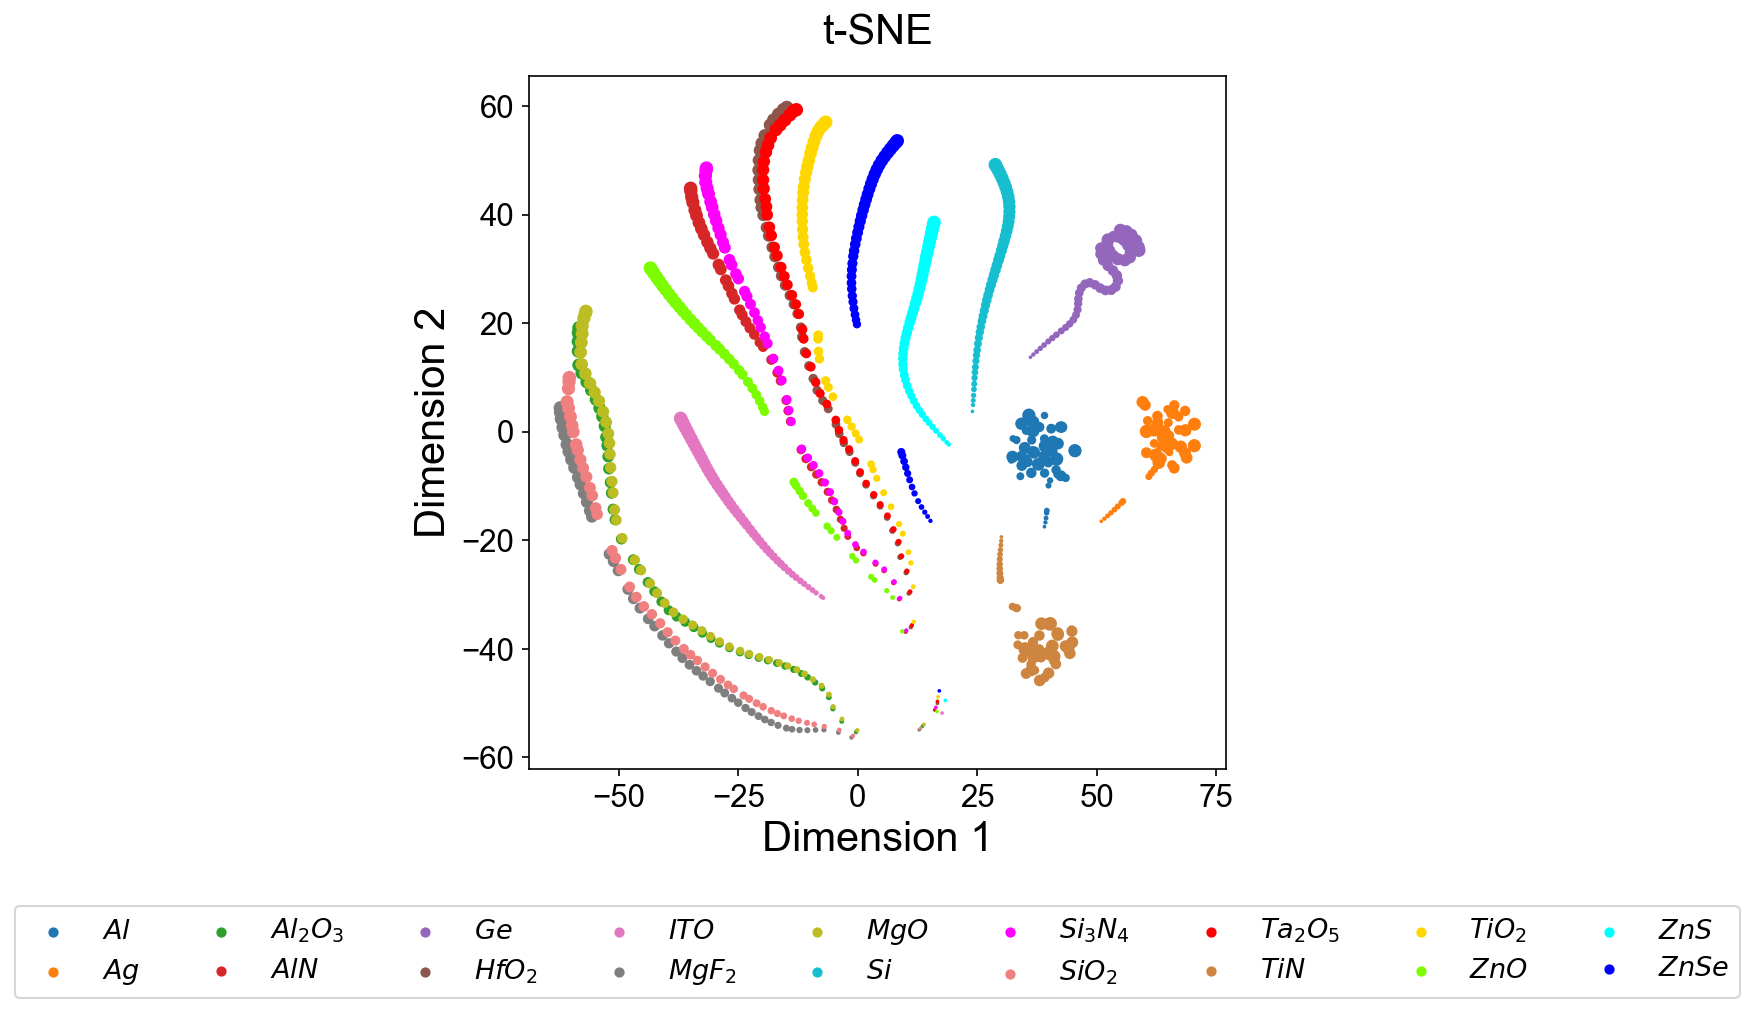

In [116]:
#####################################
import pandas as pd
import seaborn as sns

pd = pd.DataFrame(tsne_results, columns=['PCA 1', 'PCA 2'])

plt.figure(dpi=150, figsize=[6, 6], edgecolor='k')

labels = ['$Al$', '$Ag$', '$Al_2O_3$', '$AlN$', '$Ge$', '$HfO_2$', '$ITO$', '$MgF_2$', '$MgO$', '$Si$', '$Si_3N_4$', '$SiO_2$', '$Ta_2O_5$', '$TiN$', '$TiO_2$', '$ZnO$', '$ZnS$', '$ZnSe$']    
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'magenta', 'lightcoral', 'red', 'peru', 'gold', 'lawngreen', 'aqua', 'blue']

for i in range(len(mats[:-1])):
    plt.scatter(tsne_results[mat_index[mats[i]], 0], tsne_results[mat_index[mats[i]], 1], s=30*np.array([(i+1)/50 for i in range(50)]), label=labels[i], color=colors[i], alpha=1)
    

plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('PCA',fontsize=12 )

plt.xlabel('Dimension 1', fontsize=20)
plt.ylabel('Dimension 2', fontsize=20)
plt.legend(fontsize=13, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncols=9)
plt.title('t-SNE',fontsize=20, pad = 15)
